In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import MarkerCluster
from folium import PolyLine
from folium.plugins import HeatMap
from geopy.distance import geodesic
from sklearn.cluster import KMeans
import matplotlib.colors as mcolors
from sklearn.metrics import silhouette_score, silhouette_samples
from mpl_toolkits.mplot3d import Axes3D
from scipy.ndimage import uniform_filter1d


In [54]:
local_file_path = "hurdat2-1851-2023-051124.txt"

with open(local_file_path, 'r') as f:
    raw_data = f.readlines()
    
print(raw_data[:5])

['AL011851,            UNNAMED,     14,\n', '18510625, 0000,  , HU, 28.0N,  94.8W,  80, -999, -999, -999, -999, -999, -999, -999, -999, -999, -999, -999, -999, -999, -999\n', '18510625, 0600,  , HU, 28.0N,  95.4W,  80, -999, -999, -999, -999, -999, -999, -999, -999, -999, -999, -999, -999, -999, -999\n', '18510625, 1200,  , HU, 28.0N,  96.0W,  80, -999, -999, -999, -999, -999, -999, -999, -999, -999, -999, -999, -999, -999, -999\n', '18510625, 1800,  , HU, 28.1N,  96.5W,  80, -999, -999, -999, -999, -999, -999, -999, -999, -999, -999, -999, -999, -999, -999\n']


In [55]:
#func to parse the HURDAT2 file
def parse_hurdat2(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()

    data = []  #hold the storm data
    storm_metadata = []  #hold storm metadata (name, ID, etc.)

    current_storm_id = None
    current_storm_name = None

    for line in lines:
        #header line for a new storm
        if line.startswith('AL'):
            parts = line.strip().split(',')
            current_storm_id = parts[0].strip()  # ie AL011851
            current_storm_name = parts[1].strip()  # ie UNNAMED
            num_entries = int(parts[2].strip())  # no of entries for this storm
            storm_metadata.append({
                'storm_id': current_storm_id,
                'storm_name': current_storm_name,
                'num_entries': num_entries
            })
        else:
            # Data line for storm entries
            parts = line.strip().split(',')
            entry = {
                'storm_id': current_storm_id,
                'storm_name': current_storm_name,
                'date': parts[0].strip(),
                'time': parts[1].strip(),
                'record_identifier': parts[2].strip(),
                'storm_status': parts[3].strip(),
                'latitude': parts[4].strip(),
                'longitude': parts[5].strip(),
                'max_wind_speed': parts[6].strip(),
                'min_pressure': parts[7].strip(),
                # Wind radii (NE, SE, SW, NW for 34kt, 50kt, 64kt)
                '34kt_wind_NE': parts[8].strip(),
                '34kt_wind_SE': parts[9].strip(),
                '34kt_wind_SW': parts[10].strip(),
                '34kt_wind_NW': parts[11].strip(),
                '50kt_wind_NE': parts[12].strip() if len(parts) > 12 else None,
                '50kt_wind_SE': parts[13].strip() if len(parts) > 13 else None,
                '50kt_wind_SW': parts[14].strip() if len(parts) > 14 else None,
                '50kt_wind_NW': parts[15].strip() if len(parts) > 15 else None,
                '64kt_wind_NE': parts[16].strip() if len(parts) > 16 else None,
                '64kt_wind_SE': parts[17].strip() if len(parts) > 17 else None,
                '64kt_wind_SW': parts[18].strip() if len(parts) > 18 else None,
                '64kt_wind_NW': parts[19].strip() if len(parts) > 19 else None,
            }
            data.append(entry)

    #convert storm entries to df
    df = pd.DataFrame(data)
    return df, pd.DataFrame(storm_metadata)

#parse file and initialize dfs
storm_data_df, storm_metadata_df = parse_hurdat2(local_file_path)

print("Storm Data:")
print(storm_data_df.head())

print("\nStorm Metadata:")
print(storm_metadata_df.head())

Storm Data:
   storm_id storm_name      date  time record_identifier storm_status  \
0  AL011851    UNNAMED  18510625  0000                             HU   
1  AL011851    UNNAMED  18510625  0600                             HU   
2  AL011851    UNNAMED  18510625  1200                             HU   
3  AL011851    UNNAMED  18510625  1800                             HU   
4  AL011851    UNNAMED  18510625  2100                 L           HU   

  latitude longitude max_wind_speed min_pressure  ... 34kt_wind_SW  \
0    28.0N     94.8W             80         -999  ...         -999   
1    28.0N     95.4W             80         -999  ...         -999   
2    28.0N     96.0W             80         -999  ...         -999   
3    28.1N     96.5W             80         -999  ...         -999   
4    28.2N     96.8W             80         -999  ...         -999   

  34kt_wind_NW 50kt_wind_NE 50kt_wind_SE 50kt_wind_SW 50kt_wind_NW  \
0         -999         -999         -999         -999     

In [56]:
#missing or placeholder values
def preprocess_storm_data(df):
    #replace 'NA' or empty strings with NaN
    df.replace({'NA': np.nan, '': np.nan}, inplace=True)
    
    #convert numeric columns to the appropriate data type
    numeric_columns = ['max_wind_speed', 'min_pressure', 
                       '34kt_wind_NE', '34kt_wind_SE', '34kt_wind_SW', '34kt_wind_NW',
                       '50kt_wind_NE', '50kt_wind_SE', '50kt_wind_SW', '50kt_wind_NW',
                       '64kt_wind_NE', '64kt_wind_SE', '64kt_wind_SW', '64kt_wind_NW']
    for col in numeric_columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')  # Coerce invalid strings to NaN
    
    #convert date and time to a single datetime column
    df['datetime'] = pd.to_datetime(df['date'] + df['time'], format='%Y%m%d%H%M', errors='coerce')
    
    #convert lat/long to numeric
    def convert_coordinates(coord):
        if pd.isna(coord):
            return np.nan
        if coord.endswith('N'):
            return float(coord[:-1])
        elif coord.endswith('S'):
            return -float(coord[:-1])
        elif coord.endswith('E'):
            return float(coord[:-1])
        elif coord.endswith('W'):
            return -float(coord[:-1])
        return np.nan

    df['latitude'] = df['latitude'].apply(convert_coordinates)
    df['longitude'] = df['longitude'].apply(convert_coordinates)
    
    #dfo rows with invalid or missing 
    df = df.dropna(subset=['datetime', 'latitude', 'longitude'])
    
    #sort data by storm_id and datetime for consistency
    df.sort_values(by=['storm_id', 'datetime'], inplace=True)
    
    #reset index after preprocessing
    df.reset_index(drop=True, inplace=True)
    
    return df

#apply preprocessing to storm_data_df
storm_data_df = preprocess_storm_data(storm_data_df)

print("Preprocessed Storm Data:")
print(storm_data_df.head())

Preprocessed Storm Data:
   storm_id storm_name      date  time record_identifier storm_status  \
0  AL011851    UNNAMED  18510625  0000               NaN           HU   
1  AL011851    UNNAMED  18510625  0600               NaN           HU   
2  AL011851    UNNAMED  18510625  1200               NaN           HU   
3  AL011851    UNNAMED  18510625  1800               NaN           HU   
4  AL011851    UNNAMED  18510625  2100                 L           HU   

   latitude  longitude  max_wind_speed  min_pressure  ...  34kt_wind_NW  \
0      28.0      -94.8              80          -999  ...          -999   
1      28.0      -95.4              80          -999  ...          -999   
2      28.0      -96.0              80          -999  ...          -999   
3      28.1      -96.5              80          -999  ...          -999   
4      28.2      -96.8              80          -999  ...          -999   

   50kt_wind_NE  50kt_wind_SE  50kt_wind_SW  50kt_wind_NW  64kt_wind_NE  \
0         

Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54749 entries, 0 to 54748
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   storm_id           54749 non-null  object        
 1   storm_name         54749 non-null  object        
 2   date               54749 non-null  object        
 3   time               54749 non-null  object        
 4   record_identifier  1221 non-null   object        
 5   storm_status       54749 non-null  object        
 6   latitude           54749 non-null  float64       
 7   longitude          54749 non-null  float64       
 8   max_wind_speed     54749 non-null  int64         
 9   min_pressure       54749 non-null  int64         
 10  34kt_wind_NE       54749 non-null  int64         
 11  34kt_wind_SE       54749 non-null  int64         
 12  34kt_wind_SW       54749 non-null  int64         
 13  34kt_wind_NW       54749 non-null  int64   

C:\Users\nfoe\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


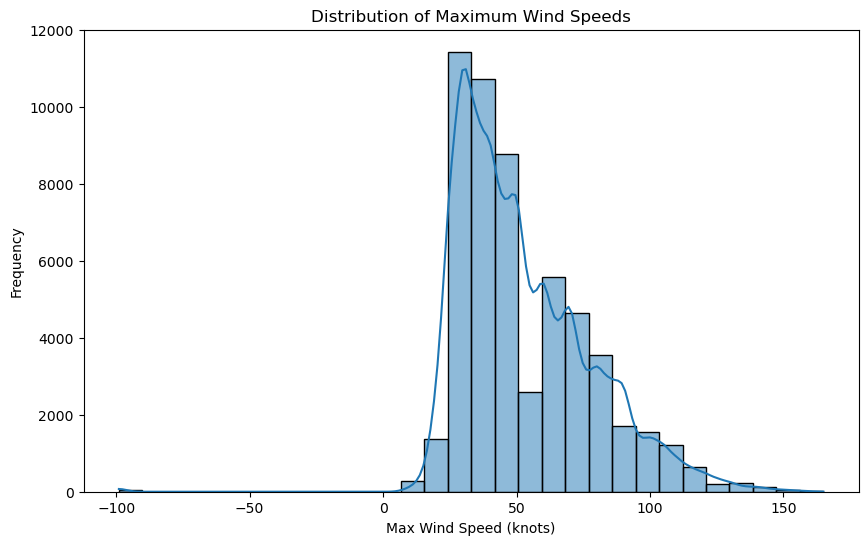

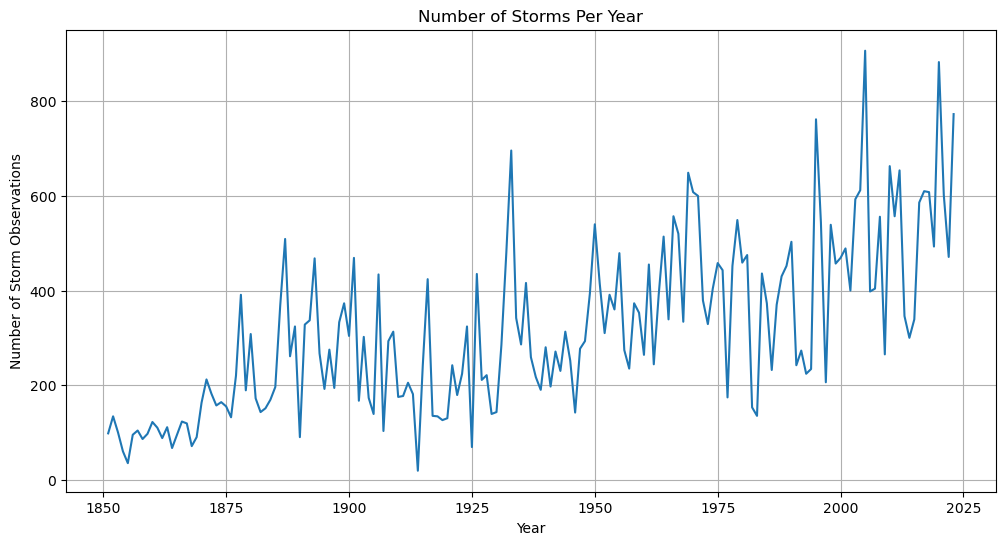

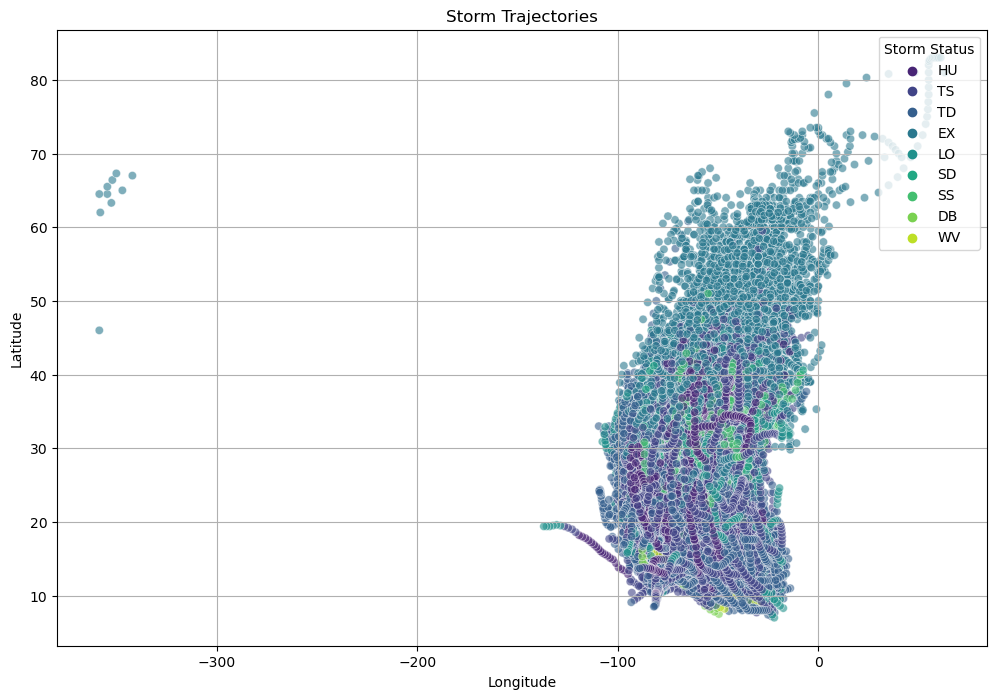

In [57]:
print("Dataset Overview:")
print(storm_data_df.info())

print("\nFirst 5 Rows of the Dataset:")
print(storm_data_df.head())

missing_values = storm_data_df.isnull().sum()
print("\nMissing Values in Each Column:")
print(missing_values)

print("\nSummary Statistics:")
print(storm_data_df.describe())

#unique storms / statuses
unique_storms = storm_data_df['storm_id'].nunique()
unique_statuses = storm_data_df['storm_status'].nunique()
print(f"\nNumber of Unique Storms: {unique_storms}")
print(f"Number of Unique Storm Statuses: {unique_statuses}")
print("Storm Status Distribution:")
print(storm_data_df['storm_status'].value_counts())

#distr of maximum wind speeds
plt.figure(figsize=(10, 6))
sns.histplot(storm_data_df['max_wind_speed'].dropna(), bins=30, kde=True)
plt.title('Distribution of Maximum Wind Speeds')
plt.xlabel('Max Wind Speed (knots)')
plt.ylabel('Frequency')
plt.show()

#trends over time
storm_data_df['year'] = storm_data_df['date'].str[:4].astype(int)  # Extract year
storms_per_year = storm_data_df.groupby('year').size()

plt.figure(figsize=(12, 6))
storms_per_year.plot(kind='line')
plt.title('Number of Storms Per Year')
plt.xlabel('Year')
plt.ylabel('Number of Storm Observations')
plt.grid()
plt.show()

#geographical patterns (scatter plot of storm trajectories)
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x=storm_data_df['longitude'].astype(float),
    y=storm_data_df['latitude'].astype(float),
    hue=storm_data_df['storm_status'],
    palette='viridis',
    alpha=0.6
)
plt.title('Storm Trajectories')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(title='Storm Status', loc='upper right')
plt.grid()
plt.show()

C:\Users\nfoe\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


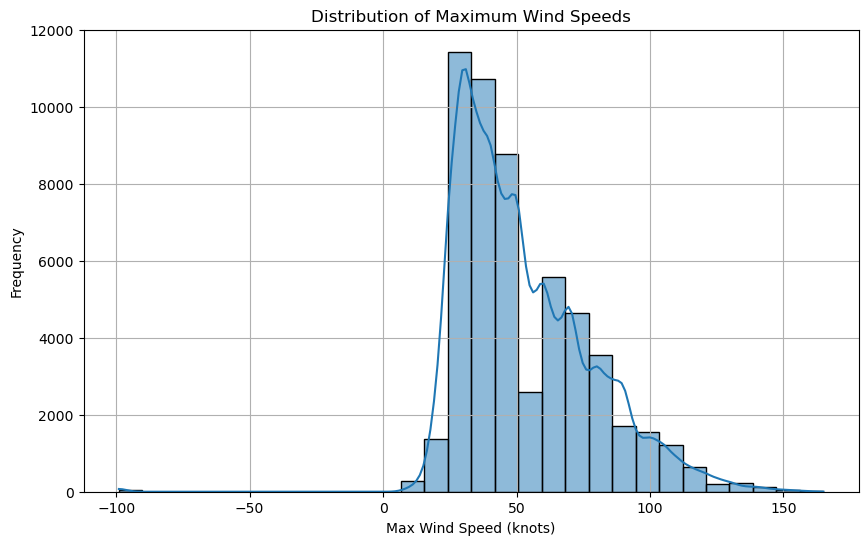

In [58]:
#ensure max_wind_speed is numeric
storm_data_df['max_wind_speed'] = pd.to_numeric(storm_data_df['max_wind_speed'], errors='coerce')

#missing or invalid values
wind_speed_data = storm_data_df['max_wind_speed'].dropna()

#distribution of maximum wind speeds
plt.figure(figsize=(10, 6))
sns.histplot(wind_speed_data, bins=30, kde=True)
plt.title('Distribution of Maximum Wind Speeds')
plt.xlabel('Max Wind Speed (knots)')
plt.ylabel('Frequency')
plt.grid()
plt.show()

C:\Users\nfoe\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


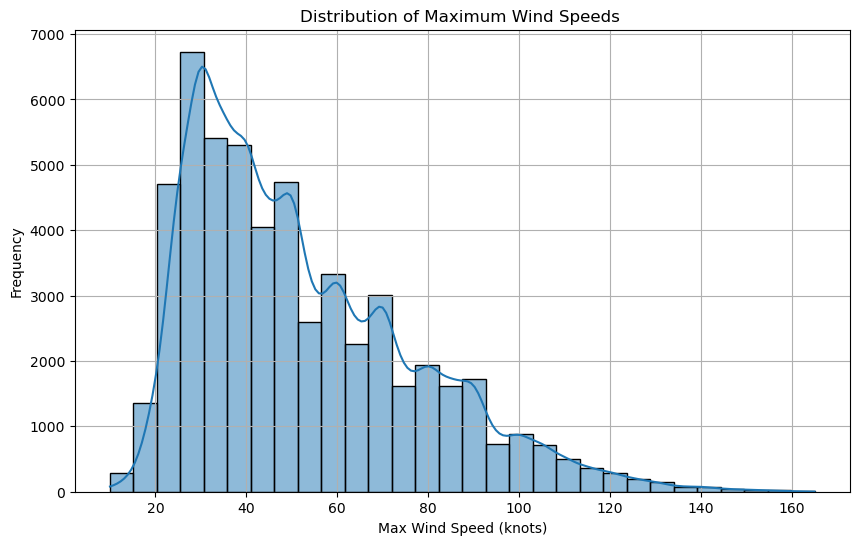

Summary Statistics for Corrected Wind Speeds:
count    54739.000000
mean        52.676209
std         24.579927
min         10.000000
25%         35.000000
50%         45.000000
75%         70.000000
max        165.000000
Name: max_wind_speed, dtype: float64


In [153]:
#ensure max_wind_speed is numeric
storm_data_df['max_wind_speed'] = pd.to_numeric(storm_data_df['max_wind_speed'], errors='coerce')

#convert negative wind speed values to positive
storm_data_df['max_wind_speed'] = storm_data_df['max_wind_speed'].abs()

#drop missing or invalid values
wind_speed_data = storm_data_df['max_wind_speed'].dropna()

#distribution of maximum wind speeds
plt.figure(figsize=(10, 6))
sns.histplot(wind_speed_data, bins=30, kde=True)
plt.title('Distribution of Maximum Wind Speeds')
plt.xlabel('Max Wind Speed (knots)')
plt.ylabel('Frequency')
plt.grid()
plt.show()

print(wind_speed_data.describe())

In [ ]:
#initialize a Folium map centered on the Atlantic
map_center = [25, -60]  #latitude and Longitude for the center of the map
m = folium.Map(location=map_center, zoom_start=4)

#add storm trajectories as points
for _, row in storm_data_df.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=3,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.5,
        popup=f"Storm Status: {row['storm_status']}<br>Max Wind Speed: {row['max_wind_speed']} knots",
    ).add_to(m)

#display map
m.save("storm_trajectories.html")
m

In [ ]:
#initialize a Folium map centered on the Atlantic
map_center = [25, -60]  #latitude and Longitude for the center of the map
m = folium.Map(location=map_center, zoom_start=4)

#MarkerCluster to reduce clutter
marker_cluster = MarkerCluster().add_to(m)

#assign colors based on storm status
status_colors = {
    'HU': 'red',  # Hurricane
    'TS': 'orange',  # Tropical Storm
    'TD': 'blue',  # Tropical Depression
    'EX': 'green',  # Extratropical
    'SS': 'purple',  # Subtropical Storm
    'SD': 'cyan',  # Subtropical Depression
    'LO': 'gray',  # Low
}

#a storm points to the cluster
for _, row in storm_data_df.iterrows():
    color = status_colors.get(row['storm_status'], 'black')  #default to black if status is unknown
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=3,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.6,
        popup=f"""
        <b>Storm ID:</b> {row['storm_id']}<br>
        <b>Status:</b> {row['storm_status']}<br>
        <b>Max Wind Speed:</b> {row['max_wind_speed']} knots<br>
        <b>Date/Time:</b> {row['date']} {row['time']}<br>
        <b>Coordinates:</b> {row['latitude']}, {row['longitude']}
        """
    ).add_to(marker_cluster)

#display map
m.save("storm_trajectories_clustered.html")
m

In [ ]:
#marker cluster with custom options
marker_cluster = MarkerCluster(
    icon_create_function="""
    function(cluster) {
        return L.divIcon({
            html: '<div style="background-color: rgba(255, 255, 255, 0.8); border-radius: 50%; padding: 10px; font-size: 14px;"><b>' + cluster.getChildCount() + '</b></div>',
            className: 'custom-cluster',
            iconSize: L.point(40, 40)
        });
    }
    """
).add_to(m)

In [ ]:
#extract genesis points (1st observation for each storm)
genesis_points = storm_data_df.groupby('storm_id').first().reset_index()

#initialize a Folium map centered on the Atlantic
map_center = [25, -60]  # Latitude and Longitude for the center of the map
m = folium.Map(location=map_center, zoom_start=4)

#add genesis points directly to the map
for _, row in genesis_points.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=5,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.8,
        popup=f"""
        <b>Storm ID:</b> {row['storm_id']}<br>
        <b>Status:</b> {row['storm_status']}<br>
        <b>Max Wind Speed:</b> {row['max_wind_speed']} knots<br>
        <b>Date/Time:</b> {row['date']} {row['time']}<br>
        <b>Coordinates:</b> {row['latitude']}, {row['longitude']}
        """
    ).add_to(m)


m.save("storm_genesis_points_no_cluster.html")
m

In [ ]:
heat_data = [[row['latitude'], row['longitude']] for _, row in genesis_points.iterrows()]
HeatMap(heat_data).add_to(m)

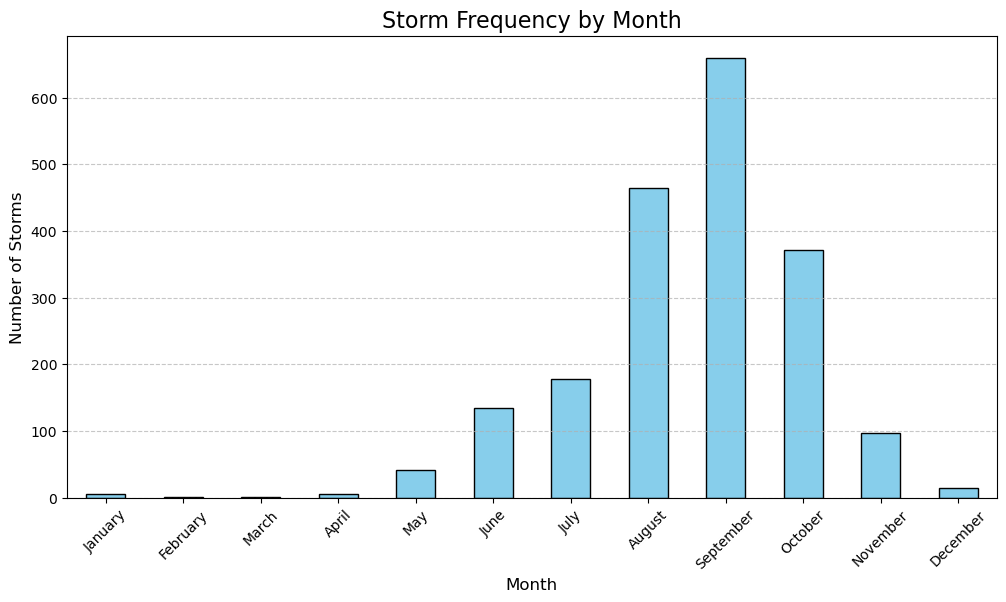

In [59]:
#datetime column
storm_data_df['date'] = pd.to_datetime(storm_data_df['date'], format='%Y%m%d', errors='coerce')

#extract the genesis points (1st observation for each storm)
genesis_points = storm_data_df.groupby('storm_id').first().reset_index()

#extract the month from the genesis dates
genesis_points['month'] = genesis_points['date'].dt.month

#count the number of storms for each month
storm_counts_by_month = genesis_points['month'].value_counts().sort_index()

#map month numbers to names
months = [
    'January', 'February', 'March', 'April', 'May', 'June',
    'July', 'August', 'September', 'October', 'November', 'December'
]
storm_counts_by_month.index = storm_counts_by_month.index.map(lambda x: months[x - 1])

#storm frequency by month
plt.figure(figsize=(12, 6))
storm_counts_by_month.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Storm Frequency by Month', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Number of Storms', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Saffir-Simpson Hurricane Wind Scale:
Category 1: 74–95 knots
Category 2: 96–110 knots
Category 3: 111–129 knots
Category 4: 130–156 knots
Category 5: ≥ 157 knots

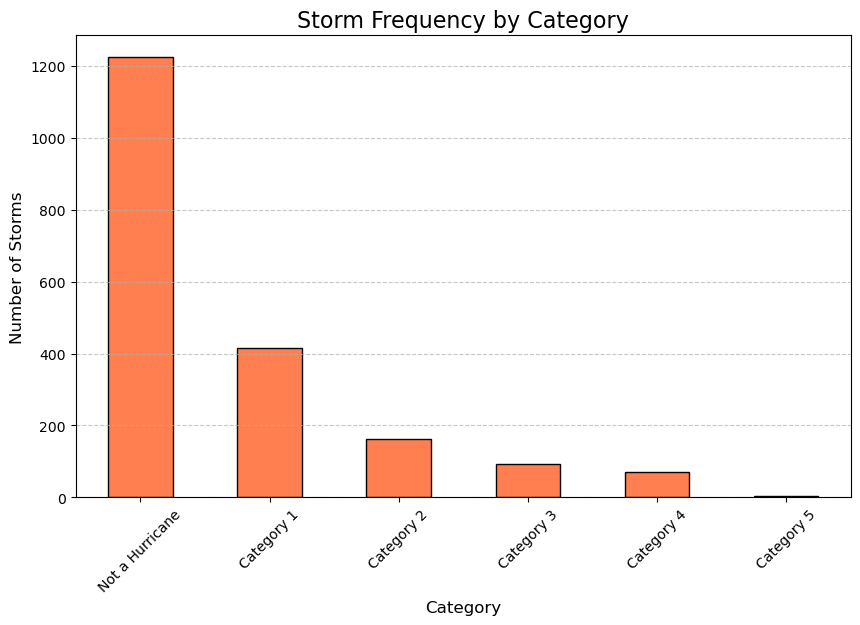

In [60]:
#def hurricane categories based on maximum wind speed
def classify_hurricane(wind_speed):
    if pd.isna(wind_speed) or wind_speed < 74:
        return 'Not a Hurricane'
    elif 74 <= wind_speed <= 95:
        return 'Category 1'
    elif 96 <= wind_speed <= 110:
        return 'Category 2'
    elif 111 <= wind_speed <= 129:
        return 'Category 3'
    elif 130 <= wind_speed <= 156:
        return 'Category 4'
    elif wind_speed >= 157:
        return 'Category 5'
    return 'Unknown'

#extract the maximum wind speed for each storm
max_wind_by_storm = storm_data_df.groupby('storm_id')['max_wind_speed'].max().reset_index()

#classify each storm by category
max_wind_by_storm['category'] = max_wind_by_storm['max_wind_speed'].apply(classify_hurricane)

#count the number of storms in each category
storm_counts_by_category = max_wind_by_storm['category'].value_counts()

#storm frequency by category
plt.figure(figsize=(10, 6))
storm_counts_by_category.plot(kind='bar', color='coral', edgecolor='black')
plt.title('Storm Frequency by Category', fontsize=16)
plt.xlabel('Category', fontsize=12)
plt.ylabel('Number of Storms', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

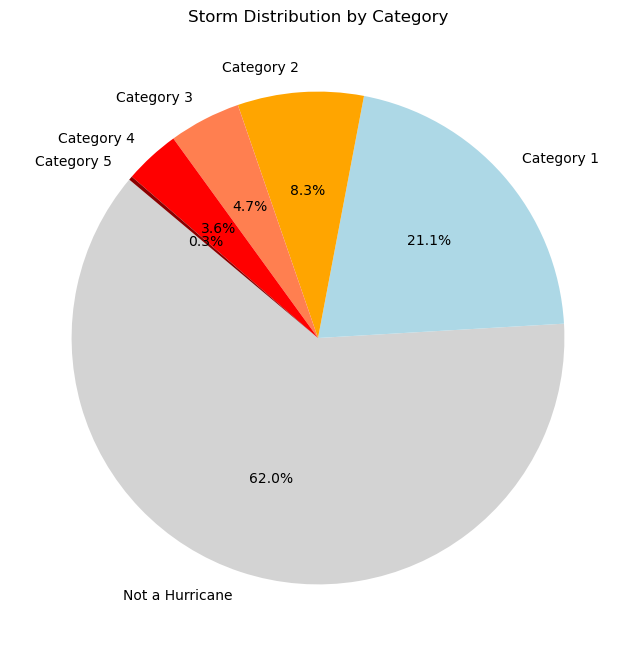

In [62]:
storm_counts_by_category.plot(kind='pie', autopct='%1.1f%%', startangle=140, figsize=(8, 8), colors=['lightgray', 'lightblue', 'orange', 'coral', 'red', 'darkred'])
plt.title('Storm Distribution by Category')
plt.ylabel('')
plt.show()

In [63]:
storm_data_df.shape

(54749, 24)

In [64]:
#def the conditions for outliers
outlier_condition = (storm_data_df['longitude'] < -300) & (storm_data_df['latitude'].between(40, 70))

#ct the number of outliers
num_outliers = storm_data_df[outlier_condition].shape[0]
print(f"Number of outlier points to drop: {num_outliers}")

#remove outliers
storm_data_df = storm_data_df[~outlier_condition]

#reset index after dropping outliers
storm_data_df.reset_index(drop=True, inplace=True)

print(f"Dataset size after removing outliers: {storm_data_df.shape}")

Number of outlier points to drop: 10
Dataset size after removing outliers: (54739, 24)


In [65]:
#storm duration
def calculate_storm_duration(df):
    #first and last observation times for each storm
    duration_df = df.groupby('storm_id')['datetime'].agg(['min', 'max']).reset_index()
    # Calculate duration in hours
    duration_df['duration_hours'] = (duration_df['max'] - duration_df['min']).dt.total_seconds() / 3600
    #merge duration back into the orig dataset
    df = df.merge(duration_df[['storm_id', 'duration_hours']], on='storm_id', how='left')
    return df

#storm trajectory distance
def calculate_storm_trajectory(df):
    #init column for trajectory distance
    df['trajectory_distance_km'] = 0.0

    #loop thru each storm and calculate trajectory distances
    for storm_id, storm_data in df.groupby('storm_id'):
        #sort by datetime for proper calculation
        storm_data = storm_data.sort_values('datetime')
        #calc distance between consecutive points
        distances = [
            geodesic((lat1, lon1), (lat2, lon2)).kilometers
            for (lat1, lon1), (lat2, lon2) in zip(
                zip(storm_data['latitude'], storm_data['longitude']),
                zip(storm_data['latitude'][1:], storm_data['longitude'][1:])
            )
        ]
        #add cumulative distance for this storm
        total_distance = sum(distances)
        df.loc[df['storm_id'] == storm_id, 'trajectory_distance_km'] = total_distance

    return df

#calc storm duration
storm_data_df = calculate_storm_duration(storm_data_df)

#calc storm trajectory distance
storm_data_df = calculate_storm_trajectory(storm_data_df)

In [66]:
#coomb 'date' and 'time' columns to create a 'datetime' column
storm_data_df['time'] = storm_data_df['time'].str.zfill(4)  # Ensure 'time' is 4 characters
storm_data_df['datetime'] = pd.to_datetime(
    storm_data_df['date'].dt.strftime('%Y-%m-%d') + ' ' + storm_data_df['time'].str[:2] + ':00:00',
    format='%Y-%m-%d %H:%M:%S',
    errors='coerce'
)

print(storm_data_df[['date', 'time', 'datetime']].head())

        date  time            datetime
0 1851-06-25  0000 1851-06-25 00:00:00
1 1851-06-25  0600 1851-06-25 06:00:00
2 1851-06-25  1200 1851-06-25 12:00:00
3 1851-06-25  1800 1851-06-25 18:00:00
4 1851-06-25  2100 1851-06-25 21:00:00


In [69]:
#storm duration
def calculate_storm_duration(df):
    # Get the first and last observation times for each storm
    duration_df = df.groupby('storm_id')['datetime'].agg(['min', 'max']).reset_index()
    # Calculate duration in hours
    duration_df['duration_hours'] = (duration_df['max'] - duration_df['min']).dt.total_seconds() / 3600
    # Merge duration back into the original dataset
    df = df.merge(duration_df[['storm_id', 'duration_hours']], on='storm_id', how='left')
    return df

#storm trajectory distance
def calculate_storm_trajectory(df):
    #init column for trajectory distance
    df['trajectory_distance_km'] = 0.0

    #loop thru each storm and calculate trajectory distances
    for storm_id, storm_data in df.groupby('storm_id'):
        #sort by datetime for proper calculation
        storm_data = storm_data.sort_values('datetime')
        #calc distance between consecutive points
        distances = [
            geodesic((lat1, lon1), (lat2, lon2)).kilometers
            for (lat1, lon1), (lat2, lon2) in zip(
                zip(storm_data['latitude'], storm_data['longitude']),
                zip(storm_data['latitude'][1:], storm_data['longitude'][1:])
            )
        ]
        #add cumulative distance for this storm
        total_distance = sum(distances)
        df.loc[df['storm_id'] == storm_id, 'trajectory_distance_km'] = total_distance

    return df

#calc storm duration
storm_data_df = calculate_storm_duration(storm_data_df)

#calc storm trajectory distance
storm_data_df = calculate_storm_trajectory(storm_data_df)

In [70]:

print(storm_data_df[['storm_id', 'datetime', 'duration_hours', 'trajectory_distance_km']])

       storm_id            datetime  duration_hours  trajectory_distance_km
0      AL011851 1851-06-25 00:00:00            72.0              716.615531
1      AL011851 1851-06-25 06:00:00            72.0              716.615531
2      AL011851 1851-06-25 12:00:00            72.0              716.615531
3      AL011851 1851-06-25 18:00:00            72.0              716.615531
4      AL011851 1851-06-25 21:00:00            72.0              716.615531
...         ...                 ...             ...                     ...
54734  AL312020 2020-11-17 12:00:00           144.0             2084.611681
54735  AL312020 2020-11-17 18:00:00           144.0             2084.611681
54736  AL312020 2020-11-18 00:00:00           144.0             2084.611681
54737  AL312020 2020-11-18 06:00:00           144.0             2084.611681
54738  AL312020 2020-11-18 12:00:00           144.0             2084.611681

[54739 rows x 4 columns]


In [71]:
#ck for exact duplicate rows across all columns
exact_duplicates = storm_data_df.duplicated()

#ct the number of exact duplicate rows
num_exact_duplicates = exact_duplicates.sum()
print(f"Number of exact duplicate rows: {num_exact_duplicates}")


if num_exact_duplicates > 0:
    print("\nExact Duplicate Rows:")
    print(storm_data_df[exact_duplicates])
else:
    print("\nNo exact duplicate rows found.")

Number of exact duplicate rows: 0

No exact duplicate rows found.


In [72]:
#earth radius in km
R = 6371

#transform latitude and longitude to Cartesian coordinates
genesis_points['lat_rad'] = np.radians(genesis_points['latitude'])
genesis_points['lon_rad'] = np.radians(genesis_points['longitude'])

genesis_points['x'] = R * np.cos(genesis_points['lat_rad']) * np.cos(genesis_points['lon_rad'])
genesis_points['y'] = R * np.cos(genesis_points['lat_rad']) * np.sin(genesis_points['lon_rad'])
genesis_points['z'] = R * np.sin(genesis_points['lat_rad'])

#cartesian coordinates for clustering
cartesian_coords = genesis_points[['x', 'y', 'z']]

C:\Users\nfoe\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\nfoe\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(
C:\Users\nfoe\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\nfoe\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than availabl

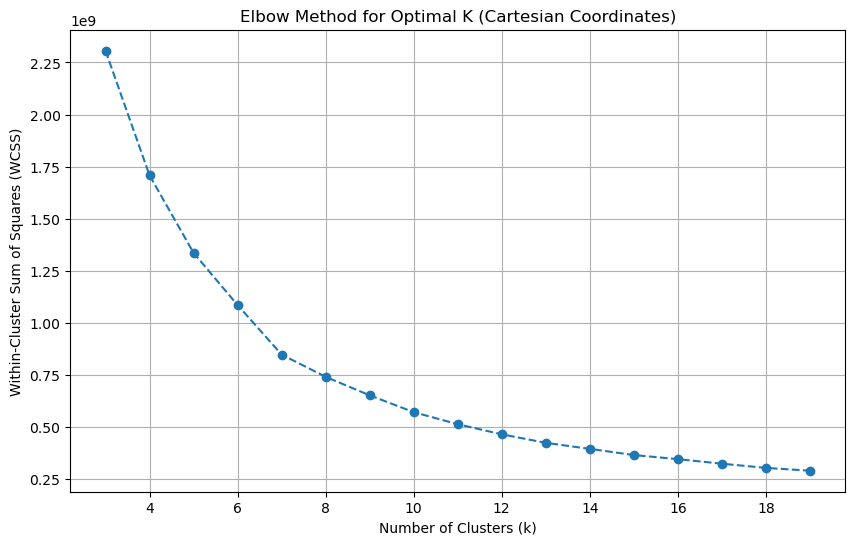

In [73]:
#re-run the elbow method with transformed coordinates
wcss = []
k_values = range(3, 20)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(cartesian_coords)
    wcss.append(kmeans.inertia_)

#elbow plot
plt.figure(figsize=(10, 6))
plt.plot(k_values, wcss, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal K (Cartesian Coordinates)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.grid()
plt.show()

In [74]:
optimal_k = 15
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
genesis_points['cluster'] = kmeans.fit_predict(cartesian_coords)

C:\Users\nfoe\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\nfoe\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(


In [33]:
#convert cluster labels to integers
#genesis_points['cluster'] = genesis_points['cluster'].astype(int)

In [75]:
genesis_points.head()

,storm_id,storm_name,date,time,record_identifier,storm_status,latitude,longitude,max_wind_speed,min_pressure,...,64kt_wind_NW,datetime,year,month,lat_rad,lon_rad,x,y,z,cluster
0,AL011851,UNNAMED,1851-06-25,0000,L,HU,28.0,-94.8,80,-999,...,-999,1851-06-25 00:00:00,1851,6,0.488692,-1.654572,-470.709551,-5605.530539,2991.003327,12
1,AL011852,UNNAMED,1852-08-19,0000,L,TS,20.5,-67.1,60,-999,...,-999,1852-08-19 00:00:00,1852,8,0.357792,-1.171116,2322.112161,-5497.209390,2231.171226,3
2,AL011853,UNNAMED,1853-08-05,1200,None,TS,32.5,-69.0,50,-999,...,-999,1853-08-05 12:00:00,1853,8,0.567232,-1.204277,1925.599474,-5016.358134,3423.135805,11
3,AL011854,UNNAMED,1854-06-25,0000,L,TS,26.0,-92.5,60,-999,...,-999,1854-06-25 00:00:00,1854,6,0.453786,-1.614430,-249.774072,-5720.766779,2792.862576,12
4,AL011855,UNNAMED,1855-08-06,1200,None,HU,22.2,-98.0,90,-999,...,-999,1855-08-06 12:00:00,1855,8,0.387463,-1.710423,-820.943362,-5841.315544,2407.223653,12


In [88]:
print(storm_data_df['storm_id'].dtype)
print(genesis_points.index.dtype)
print(genesis_points['storm_id'].dtype)

object
object
object


In [77]:
#convert the index of genesis_points to string
genesis_points.index = genesis_points.index.astype(str)

In [78]:
#strip leading/trailing spaces (if any)
storm_data_df['storm_id'] = storm_data_df['storm_id'].str.strip()
genesis_points.index = genesis_points.index.str.strip()

#ensure both are strings
storm_data_df['storm_id'] = storm_data_df['storm_id'].astype(str)
genesis_points.index = genesis_points.index.astype(str)

In [90]:
#ckthe unique values in both
print("Unique storm_id in storm_data_df:", storm_data_df['storm_id'].unique()[:5])
print("Unique index in genesis_points:", genesis_points.index.unique()[:5])

#common values
common_ids = set(storm_data_df['storm_id']).intersection(set(genesis_points.index))
print(f"Number of matching storm_ids: {len(common_ids)}")

Unique storm_id in storm_data_df: ['AL011851' 'AL011852' 'AL011853' 'AL011854' 'AL011855']
Unique index in genesis_points: Index(['0', '1', '2', '3', '4'], dtype='object')
Number of matching storm_ids: 0


In [91]:
#merge using the storm_id column 
storm_data_df = storm_data_df.merge(
    genesis_points[['storm_id', 'cluster']],  
    on='storm_id',  #merge on the storm_id column
    how='left'      #preserve all rows in storm_data_df
)

print(storm_data_df[['storm_id', 'cluster']].head())

   storm_id  cluster
0  AL011851       12
1  AL011851       12
2  AL011851       12
3  AL011851       12
4  AL011851       12


In [ ]:
#init a Folium map centered on the Atlantic
map_center = [25, -60]  # Latitude and Longitude for the center of the map
m = folium.Map(location=map_center, zoom_start=4)

#def a color palette for clusters
colors = list(mcolors.TABLEAU_COLORS.values())  #choose colors
num_clusters = genesis_points['cluster'].nunique()

#add genesis points to the map with cluster-specific colors
for _, row in genesis_points.iterrows():
    cluster_color = colors[row['cluster'] % len(colors)]  #cycle through colors if clusters > palette
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=5,
        color=cluster_color,
        fill=True,
        fill_color=cluster_color,
        fill_opacity=0.8,
        popup=f"""
        <b>Latitude:</b> {row['latitude']}<br>
        <b>Longitude:</b> {row['longitude']}<br>
        <b>Cluster:</b> {row['cluster']}
        """
    ).add_to(m)

m.save("storm_genesis_clusters.html")
m

C:\Users\nfoe\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\nfoe\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(


Average Silhouette Score for k=15: 0.42


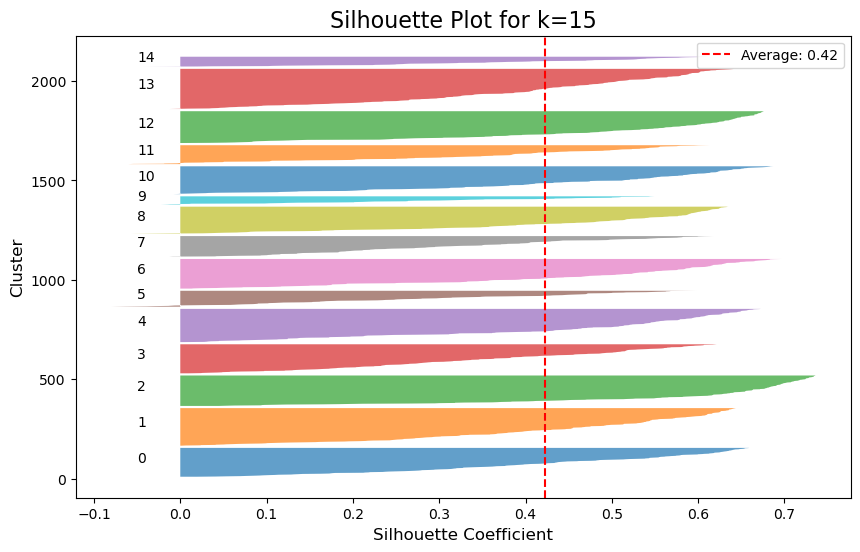

In [80]:
#cartesian coordinates for clustering
cartesian_coords = genesis_points[['x', 'y', 'z']]

#fit K-Means with 15 clusters
optimal_k = 15
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
genesis_points['cluster'] = kmeans.fit_predict(cartesian_coords)

#compute silhouette score for the entire dataset
silhouette_avg = silhouette_score(cartesian_coords, genesis_points['cluster'])
print(f"Average Silhouette Score for k={optimal_k}: {silhouette_avg:.2f}")

#compute silhouette scores for each sample
sample_silhouette_values = silhouette_samples(cartesian_coords, genesis_points['cluster'])

#viz silhouette scores
plt.figure(figsize=(10, 6))
y_lower = 10
for i in range(optimal_k):
    # Aggregate silhouette scores for the current cluster
    ith_cluster_silhouette_values = sample_silhouette_values[genesis_points['cluster'] == i]
    ith_cluster_silhouette_values.sort()
    
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    
    # Fill the silhouette plot
    plt.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      alpha=0.7)
    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    
    y_lower = y_upper + 10  # Add spacing between clusters

plt.title(f"Silhouette Plot for k={optimal_k}", fontsize=16)
plt.xlabel("Silhouette Coefficient", fontsize=12)
plt.ylabel("Cluster", fontsize=12)
plt.axvline(x=silhouette_avg, color="red", linestyle="--", label=f"Average: {silhouette_avg:.2f}")
plt.legend()
plt.show()

C:\Users\nfoe\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\nfoe\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(
C:\Users\nfoe\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\nfoe\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than availabl

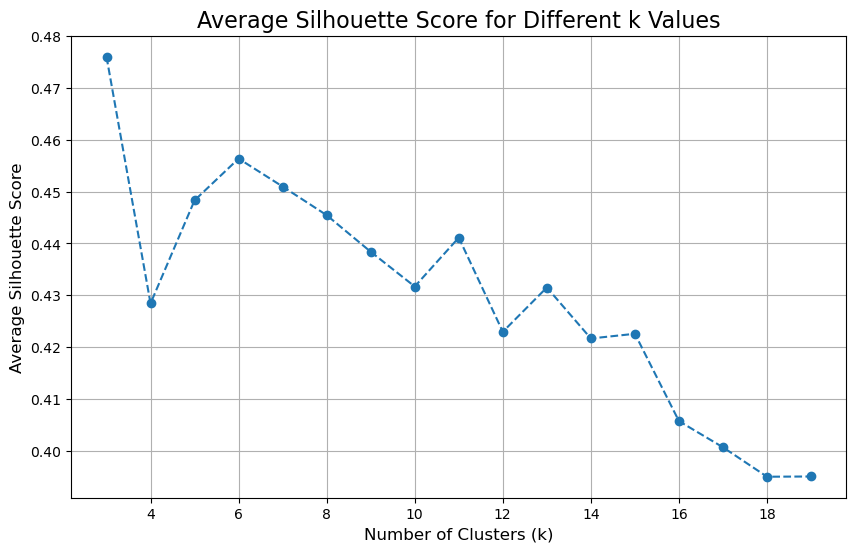

In [81]:
#range of cluster numbers to evaluate
k_values = range(3, 20)
silhouette_scores = []

#calc silhouette scores for each k
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(cartesian_coords)
    score = silhouette_score(cartesian_coords, kmeans.labels_)
    silhouette_scores.append(score)


plt.figure(figsize=(10, 6))
plt.plot(k_values, silhouette_scores, marker='o', linestyle='--')
plt.title('Average Silhouette Score for Different k Values', fontsize=16)
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Average Silhouette Score', fontsize=12)
plt.grid()
plt.show()

C:\Users\nfoe\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\nfoe\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(


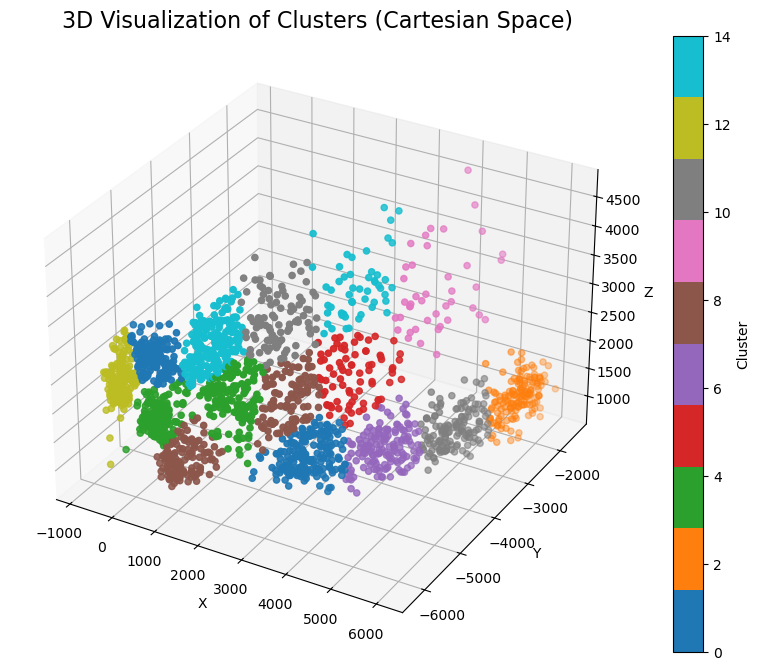

In [82]:
#fit K-Means
kmeans = KMeans(n_clusters=15, random_state=42)
genesis_points['cluster'] = kmeans.fit_predict(cartesian_coords)

#3D scatter plot of clusters
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(
    genesis_points['x'], genesis_points['y'], genesis_points['z'],
    c=genesis_points['cluster'], cmap='tab10', s=20
)
ax.set_title('3D Visualization of Clusters (Cartesian Space)', fontsize=16)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.colorbar(scatter, ax=ax, label='Cluster')
plt.show()

In [ ]:

m = folium.Map(location=[25, -60], zoom_start=4)

#add heatmap for each cluster
for cluster in genesis_points['cluster'].unique():
    cluster_data = genesis_points[genesis_points['cluster'] == cluster]
    heat_data = cluster_data[['latitude', 'longitude']].values.tolist()
    HeatMap(heat_data, name=f'Cluster {cluster}').add_to(m)


m.save("storm_cluster_heatmap.html")
m

In [93]:
#compute cluster statistics
cluster_stats = genesis_points.groupby('cluster').agg(
    num_points=('latitude', 'size'),
    avg_latitude=('latitude', 'mean'),
    avg_longitude=('longitude', 'mean')
).reset_index()


print(cluster_stats)

    cluster  num_points  avg_latitude  avg_longitude
0         0         146     26.275342     -87.570548
1         1         190     13.894211     -57.436316
2         2         154     12.957792     -21.411688
3         3         147     22.215646     -70.807483
4         4         168     18.699405     -84.181548
5         5          81     23.906173     -50.272840
6         6         150     13.056000     -45.170667
7         7         105     21.815238     -61.110476
8         8         138     13.502899     -78.739130
9         9          42     32.497619     -34.033333
10       10         141     12.716312     -33.304965
11       11          96     32.722917     -64.429167
12       12         161     21.827950     -93.789441
13       13         203     29.320690     -76.402463
14       14          51     35.790196     -49.300000


In [84]:
#calc silhouette score
silhouette_avg = silhouette_score(cartesian_coords, genesis_points['cluster'])
print(f"Silhouette Score for k={optimal_k}: {silhouette_avg:.2f}")

Silhouette Score for k=15: 0.42


In [85]:
#convert latitude and longitude to radians
storm_data_df['lat_rad'] = np.radians(storm_data_df['latitude'])
storm_data_df['lon_rad'] = np.radians(storm_data_df['longitude'])

#compute Cartesian coordinates
storm_data_df['x'] = R * np.cos(storm_data_df['lat_rad']) * np.cos(storm_data_df['lon_rad'])
storm_data_df['y'] = R * np.cos(storm_data_df['lat_rad']) * np.sin(storm_data_df['lon_rad'])
storm_data_df['z'] = R * np.sin(storm_data_df['lat_rad'])

In [86]:
def calculate_features(group):
    #Zonal Speed (U)
    group['U'] = (group['longitude'].diff() / 6) * np.cos(np.radians(group['latitude'])) * 60 * 1.15
    
    #Meridional Speed (V)
    group['V'] = (group['latitude'].diff() / 6) * 60 * 1.15
    
    #12-hour Change in intensity (DVMX)
    group['DVMX'] = group['max_wind_speed'].diff(periods=2)  # 12 hours = 2 time steps of 6 hours
    
    return group

# Ensure storm_id is not in the index
#if 'storm_id' in storm_data_df.index.names:
    #storm_data_df = storm_data_df.reset_index(level='storm_id', drop=True)

#group by storm_id and apply feature engineering
storm_data_df = storm_data_df.groupby('storm_id', group_keys=False).apply(calculate_features)

#fill missing values for U, V, and DVMX
storm_data_df['U'] = storm_data_df['U'].fillna(0)
storm_data_df['V'] = storm_data_df['V'].fillna(0)
storm_data_df['DVMX'] = storm_data_df['DVMX'].fillna(0)


print(storm_data_df[['storm_id', 'latitude', 'longitude', 'U', 'V', 'DVMX']].head())


   storm_id  latitude  longitude         U     V  DVMX
0  AL011851      28.0      -94.8  0.000000  0.00   0.0
1  AL011851      28.0      -95.4 -6.092338  0.00   0.0
2  AL011851      28.0      -96.0 -6.092338  0.00   0.0
3  AL011851      28.1      -96.5 -5.072229  1.15   0.0
4  AL011851      28.2      -96.8 -3.040497  1.15   0.0


In [87]:
storm_data_df.head()

,storm_id,storm_name,date,time,record_identifier,storm_status,latitude,longitude,max_wind_speed,min_pressure,...,duration_hours,cluster,lat_rad,lon_rad,x,y,z,U,V,DVMX
0,AL011851,UNNAMED,1851-06-25,0000,NaN,HU,28.0,-94.8,80,-999,...,72.0,NaN,0.488692,-1.654572,-470.709551,-5605.530539,2991.003327,0.000000,0.00,0.0
1,AL011851,UNNAMED,1851-06-25,0600,NaN,HU,28.0,-95.4,80,-999,...,72.0,NaN,0.488692,-1.665044,-529.383647,-5600.294015,2991.003327,-6.092338,0.00,0.0
2,AL011851,UNNAMED,1851-06-25,1200,NaN,HU,28.0,-96.0,80,-999,...,72.0,NaN,0.488692,-1.675516,-587.999691,-5594.443356,2991.003327,-6.092338,0.00,0.0
3,AL011851,UNNAMED,1851-06-25,1800,NaN,HU,28.1,-96.5,80,-999,...,72.0,NaN,0.490438,-1.684243,-636.205487,-5583.903898,3000.816695,-5.072229,1.15,0.0
4,AL011851,UNNAMED,1851-06-25,2100,L,HU,28.2,-96.8,80,-999,...,72.0,NaN,0.492183,-1.689479,-664.812741,-5575.287139,3010.620923,-3.040497,1.15,0.0


In [95]:
storm_data_df.columns

Index(['storm_id', 'storm_name', 'date', 'time', 'record_identifier',
       'storm_status', 'latitude', 'longitude', 'max_wind_speed',
       'min_pressure', '34kt_wind_NE', '34kt_wind_SE', '34kt_wind_SW',
       '34kt_wind_NW', '50kt_wind_NE', '50kt_wind_SE', '50kt_wind_SW',
       '50kt_wind_NW', '64kt_wind_NE', '64kt_wind_SE', '64kt_wind_SW',
       '64kt_wind_NW', 'datetime', 'year', 'duration_hours_x',
       'trajectory_distance_km', 'duration_hours_y', 'duration_hours',
       'cluster_x', 'lat_rad', 'lon_rad', 'x', 'y', 'z', 'U', 'V', 'DVMX',
       'cluster_y', 'cluster'],
      dtype='object')

In [99]:
print(storm_data_df[['duration_hours','duration_hours_x', 'duration_hours_y', 'cluster','cluster_x', 'cluster_y']].head())

   duration_hours  duration_hours_x  duration_hours_y  cluster  cluster_x  \
0            72.0              72.0              72.0       12        NaN   
1            72.0              72.0              72.0       12        NaN   
2            72.0              72.0              72.0       12        NaN   
3            72.0              72.0              72.0       12        NaN   
4            72.0              72.0              72.0       12        NaN   

   cluster_y  
0        NaN  
1        NaN  
2        NaN  
3        NaN  
4        NaN  


In [100]:
storm_data_df = storm_data_df.drop(columns=['duration_hours_x', 'duration_hours_y','cluster_x','cluster_y'])

In [101]:
#create a timestep feature for each row
storm_data_df['timestep'] = storm_data_df.apply(
    lambda row: {
        'lat': row['latitude'],
        'long': row['longitude'],
        'max-wind': row['max_wind_speed'],
        'entry-time': row['datetime']
    },
    axis=1
)


print(storm_data_df[['timestep']].head())


                                            timestep
0  {'lat': 28.0, 'long': -94.8, 'max-wind': 80, '...
1  {'lat': 28.0, 'long': -95.4, 'max-wind': 80, '...
2  {'lat': 28.0, 'long': -96.0, 'max-wind': 80, '...
3  {'lat': 28.1, 'long': -96.5, 'max-wind': 80, '...
4  {'lat': 28.2, 'long': -96.8, 'max-wind': 80, '...


In [137]:
# Sort by storm_id and datetime to ensure proper time sequence
#storm_data_df = storm_data_df.sort_values(by=['storm_id', 'datetime'])

# Calculate wind speed change per observation
#storm_data_df['wind_speed_change'] = storm_data_df.groupby('storm_id')['max_wind_speed'].diff() / storm_data_df.groupby('storm_id')['duration_hours'].diff()

# Fill missing values with 0 for the first observation of each storm
#storm_data_df['wind_speed_change'] = storm_data_df['wind_speed_change'].fillna(0)

# Preview the new feature
#print(storm_data_df[['storm_id','max_wind_speed', 'wind_speed_change']].head())


In [138]:
#storm_data_df["wind_speed_change"].describe()

In [115]:
storm_data_df["duration_hours"].describe()

count    54739.000000
mean       222.443760
std        119.353599
min          0.000001
25%        126.000000
50%        204.000000
75%        294.000000
max        786.000000
Name: duration_hours, dtype: float64

In [116]:
#check rows where duration_hours is 0
zero_duration_rows = storm_data_df[storm_data_df['duration_hours'] == 0]
print(zero_duration_rows[['storm_id', 'datetime', 'duration_hours']])

Empty DataFrame
Columns: [storm_id, datetime, duration_hours]
Index: []


In [109]:
storm_data_df['duration_hours'] = storm_data_df['duration_hours'].replace(0, 1e-6)

In [126]:
def calculate_delta_wind(group):
    #init delta_wind with zeros
    group['delta_wind'] = 0
    
    #loop through rows in the group
    for i in range(1, len(group)):
        current = group.iloc[i]
        previous = group.iloc[i - 1]
        
        #calc time difference in hours
        time_diff = (current['datetime'] - previous['datetime']).total_seconds() / 3600
        time_diff = time_diff if time_diff != 0 else 1e-6  # Avoid division by zero

        #calc delta_wind
        group.loc[group.index[i], 'delta_wind'] = (current['max_wind_speed'] - previous['max_wind_speed']) / time_diff

    return group

#apply to grouped df
storm_data_df = storm_data_df.groupby('storm_id', group_keys=False).apply(calculate_delta_wind)


print(storm_data_df[['storm_id', 'datetime', 'max_wind_speed', 'delta_wind']].head(10))


C:\Users\nfoe\AppData\Local\Temp\ipykernel_25544\490428255.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-3.3333333333333335' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  group.loc[group.index[i], 'delta_wind'] = (current['max_wind_speed'] - previous['max_wind_speed']) / time_diff
C:\Users\nfoe\AppData\Local\Temp\ipykernel_25544\490428255.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '1.6666666666666667' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  group.loc[group.index[i], 'delta_wind'] = (current['max_wind_speed'] - previous['max_wind_speed']) / time_diff
C:\Users\nfoe\AppData\Local\Temp\ipykernel_25544\490428255.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-1.6666

   storm_id            datetime  max_wind_speed  delta_wind
0  AL011851 1851-06-25 00:00:00              80    0.000000
1  AL011851 1851-06-25 06:00:00              80    0.000000
2  AL011851 1851-06-25 12:00:00              80    0.000000
3  AL011851 1851-06-25 18:00:00              80    0.000000
4  AL011851 1851-06-25 21:00:00              80    0.000000
5  AL011851 1851-06-26 00:00:00              70   -3.333333
6  AL011851 1851-06-26 06:00:00              60   -1.666667
7  AL011851 1851-06-26 12:00:00              60    0.000000
8  AL011851 1851-06-26 18:00:00              50   -1.666667
9  AL011851 1851-06-27 00:00:00              50    0.000000


In [127]:

print(storm_data_df[['storm_id', 'datetime', 'max_wind_speed','delta_wind']].head(10))

    storm_id            datetime  max_wind_speed  delta_wind
0   AL011851 1851-06-25 00:00:00              80    0.000000
1   AL011851 1851-06-25 06:00:00              80    0.000000
2   AL011851 1851-06-25 12:00:00              80    0.000000
3   AL011851 1851-06-25 18:00:00              80    0.000000
4   AL011851 1851-06-25 21:00:00              80    0.000000
5   AL011851 1851-06-26 00:00:00              70   -3.333333
6   AL011851 1851-06-26 06:00:00              60   -1.666667
7   AL011851 1851-06-26 12:00:00              60    0.000000
8   AL011851 1851-06-26 18:00:00              50   -1.666667
9   AL011851 1851-06-27 00:00:00              50    0.000000
10  AL011851 1851-06-27 06:00:00              40   -1.666667
11  AL011851 1851-06-27 12:00:00              40    0.000000
12  AL011851 1851-06-27 18:00:00              40    0.000000
13  AL011851 1851-06-28 00:00:00              40    0.000000
14  AL011852 1852-08-19 00:00:00              60    0.000000
15  AL011852 1852-08-19 

In [129]:
storm_data_df["delta_wind"].describe()

count    5.473900e+04
mean    -9.134613e+01
std      2.137084e+04
min     -5.000000e+06
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.316667e+01
Name: delta_wind, dtype: float64

In [140]:
#ck rows with extreme delta_wind values
extreme_rows = storm_data_df[(storm_data_df['delta_wind'] < -100) | (storm_data_df['delta_wind'] > 100)]
print(extreme_rows[['storm_id', 'datetime', 'max_wind_speed', 'delta_wind']])


Empty DataFrame
Columns: [storm_id, datetime, max_wind_speed, delta_wind]
Index: []


In [131]:
def calculate_time_diff(group):
    group['time_diff'] = group['datetime'].diff().dt.total_seconds() / 3600
    return group

storm_data_df = storm_data_df.groupby('storm_id', group_keys=False).apply(calculate_time_diff)

#ck extreme cases of time_diff
extreme_time_diff = storm_data_df[(storm_data_df['time_diff'] < 0) | (storm_data_df['time_diff'] > 24)]
print(extreme_time_diff[['storm_id', 'datetime', 'time_diff']])


Empty DataFrame
Columns: [storm_id, datetime, time_diff]
Index: []


In [132]:
def recalculate_delta_wind(group):
    group['delta_wind'] = 0  # Initialize
    for i in range(1, len(group)):
        current = group.iloc[i]
        previous = group.iloc[i - 1]

        # Calculate time difference
        time_diff = current['time_diff']
        if time_diff == 0 or pd.isna(time_diff):
            continue  # Skip invalid cases

        # Calculate delta_wind
        group.loc[group.index[i], 'delta_wind'] = (
            (current['max_wind_speed'] - previous['max_wind_speed']) / time_diff
        )
    return group

storm_data_df = storm_data_df.groupby('storm_id', group_keys=False).apply(recalculate_delta_wind)


C:\Users\nfoe\AppData\Local\Temp\ipykernel_25544\1649968876.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-3.3333333333333335' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  group.loc[group.index[i], 'delta_wind'] = (
C:\Users\nfoe\AppData\Local\Temp\ipykernel_25544\1649968876.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '1.6666666666666667' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  group.loc[group.index[i], 'delta_wind'] = (
C:\Users\nfoe\AppData\Local\Temp\ipykernel_25544\1649968876.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-1.6666666666666667' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  group.loc[group.index[i], 'd

In [133]:
print(storm_data_df['delta_wind'].describe())


count    54739.000000
mean        -0.003578
std          1.079498
min        -17.500000
25%          0.000000
50%          0.000000
75%          0.000000
max         13.166667
Name: delta_wind, dtype: float64


In [135]:
print(storm_data_df[['storm_id', 'datetime', 'max_wind_speed','delta_wind']].head(20))

    storm_id            datetime  max_wind_speed  delta_wind
0   AL011851 1851-06-25 00:00:00              80    0.000000
1   AL011851 1851-06-25 06:00:00              80    0.000000
2   AL011851 1851-06-25 12:00:00              80    0.000000
3   AL011851 1851-06-25 18:00:00              80    0.000000
4   AL011851 1851-06-25 21:00:00              80    0.000000
5   AL011851 1851-06-26 00:00:00              70   -3.333333
6   AL011851 1851-06-26 06:00:00              60   -1.666667
7   AL011851 1851-06-26 12:00:00              60    0.000000
8   AL011851 1851-06-26 18:00:00              50   -1.666667
9   AL011851 1851-06-27 00:00:00              50    0.000000
10  AL011851 1851-06-27 06:00:00              40   -1.666667
11  AL011851 1851-06-27 12:00:00              40    0.000000
12  AL011851 1851-06-27 18:00:00              40    0.000000
13  AL011851 1851-06-28 00:00:00              40    0.000000
14  AL011852 1852-08-19 00:00:00              60    0.000000
15  AL011852 1852-08-19 

In [141]:
storm_data_df.columns

Index(['storm_id', 'storm_name', 'date', 'time', 'record_identifier',
       'storm_status', 'latitude', 'longitude', 'max_wind_speed',
       'min_pressure', '34kt_wind_NE', '34kt_wind_SE', '34kt_wind_SW',
       '34kt_wind_NW', '50kt_wind_NE', '50kt_wind_SE', '50kt_wind_SW',
       '50kt_wind_NW', '64kt_wind_NE', '64kt_wind_SE', '64kt_wind_SW',
       '64kt_wind_NW', 'datetime', 'year', 'trajectory_distance_km',
       'duration_hours', 'lat_rad', 'lon_rad', 'x', 'y', 'z', 'U', 'V', 'DVMX',
       'cluster', 'timestep', 'wind_speed_change', 'duration_diff',
       'delta_wind', 'time_diff'],
      dtype='object')

In [143]:
storm_data_df = storm_data_df.drop(columns=['wind_speed_change', 'duration_diff'])

In [144]:
#one-hot encoding for clusters
clusters_encoded = pd.get_dummies(storm_data_df['cluster'], prefix='cluster')

#encoded clusters back to the main df
storm_data_df = pd.concat([storm_data_df, clusters_encoded], axis=1)

print(storm_data_df.head())

   storm_id storm_name       date  time record_identifier storm_status  \
0  AL011851    UNNAMED 1851-06-25  0000               NaN           HU   
1  AL011851    UNNAMED 1851-06-25  0600               NaN           HU   
2  AL011851    UNNAMED 1851-06-25  1200               NaN           HU   
3  AL011851    UNNAMED 1851-06-25  1800               NaN           HU   
4  AL011851    UNNAMED 1851-06-25  2100                 L           HU   

   latitude  longitude  max_wind_speed  min_pressure  ...  cluster_5  \
0      28.0      -94.8              80          -999  ...      False   
1      28.0      -95.4              80          -999  ...      False   
2      28.0      -96.0              80          -999  ...      False   
3      28.1      -96.5              80          -999  ...      False   
4      28.2      -96.8              80          -999  ...      False   

   cluster_6  cluster_7  cluster_8  cluster_9  cluster_10  cluster_11  \
0      False      False      False      False    

In [145]:
#save storm_data_df to a Parquet file
storm_data_df.to_parquet('storm_data_df.parquet', index=False)
print("storm_data_df saved as 'storm_data_df.parquet'")

storm_data_df saved as 'storm_data_df.parquet'


In [146]:
#CSV file
storm_data_df.to_csv('storm_data_df.csv', index=False)
print("storm_data_df saved as 'storm_data_df.csv'")

storm_data_df saved as 'storm_data_df.csv'


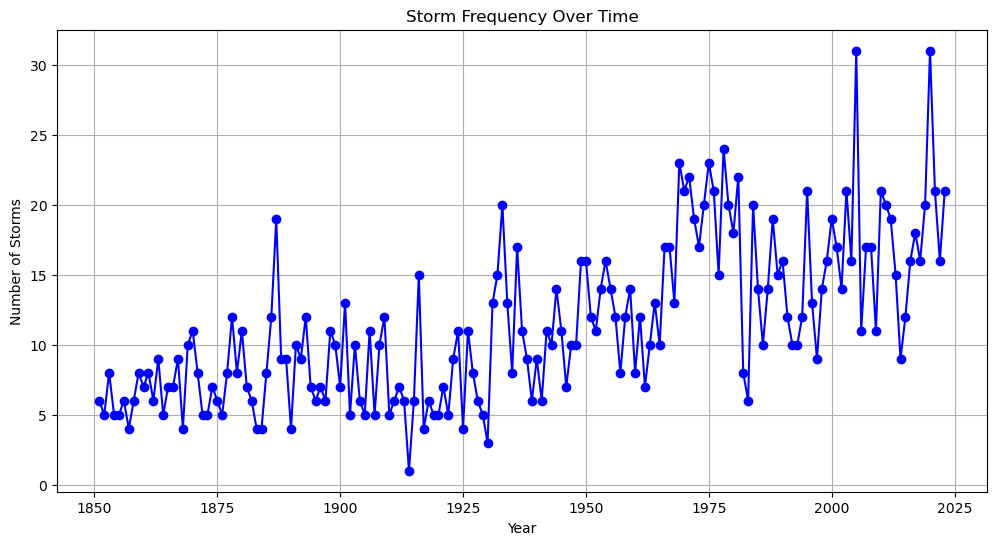

In [147]:
storm_data_df['year'] = storm_data_df['datetime'].dt.year

#ct the number of storms per year
storm_frequency = storm_data_df.groupby('year')['storm_id'].nunique()

#storm frequency over time
plt.figure(figsize=(12, 6))
plt.plot(storm_frequency.index, storm_frequency.values, marker='o', linestyle='-', color='blue')
plt.xlabel('Year')
plt.ylabel('Number of Storms')
plt.title('Storm Frequency Over Time')
plt.grid()
plt.show()

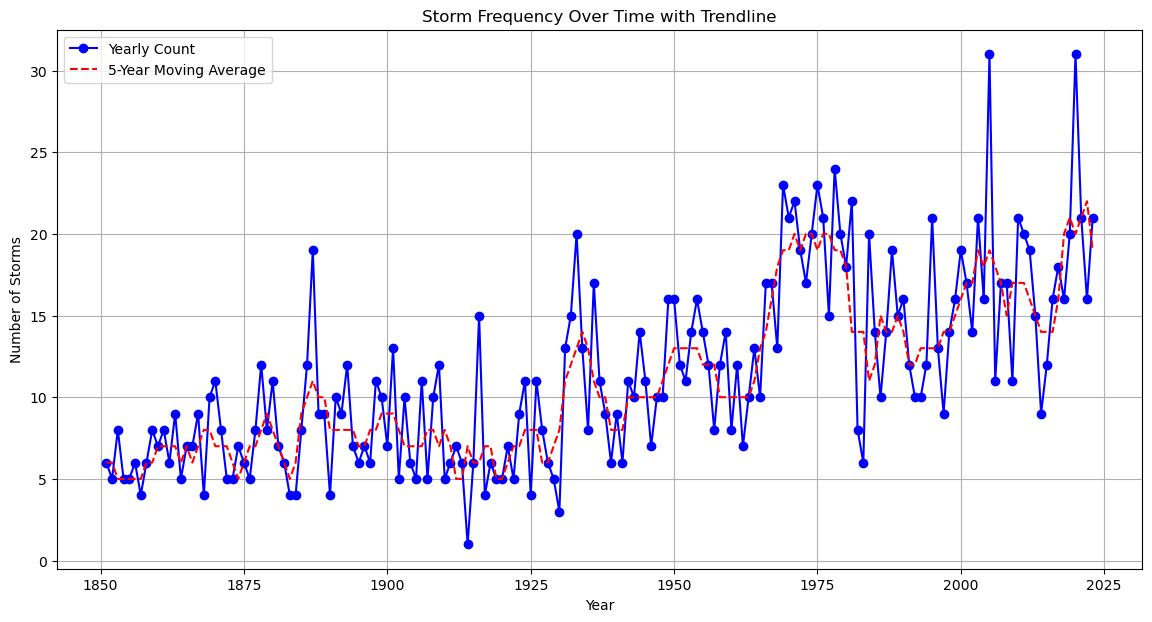

In [151]:
#datetime column is in the correct format
storm_data_df['datetime'] = pd.to_datetime(storm_data_df['datetime'])

#year from the datetime column
storm_data_df['year'] = storm_data_df['datetime'].dt.year

#ct the number of storms per year
storm_frequency = storm_data_df.groupby('year')['storm_id'].nunique()

#calc moving average for the trendline
moving_avg = uniform_filter1d(storm_frequency.values, size=5)

plt.figure(figsize=(14, 7))
plt.plot(storm_frequency.index, storm_frequency.values, marker='o', linestyle='-', color='blue', label='Yearly Count')
plt.plot(storm_frequency.index, moving_avg, color='red', linestyle='--', label='5-Year Moving Average')

#highlight a specific year
#max_year = storm_frequency.idxmax()
#plt.scatter(max_year, storm_frequency[max_year], color='green', zorder=5)
#plt.text(max_year, storm_frequency[max_year] + 1, f'Peak Year: {max_year}', color='green', fontsize=10)

#labels, title, and legend
plt.xlabel('Year')
plt.ylabel('Number of Storms')
plt.title('Storm Frequency Over Time with Trendline')
plt.legend()
plt.grid()
plt.show()

In [152]:
storm_data_df.shape

(54739, 53)

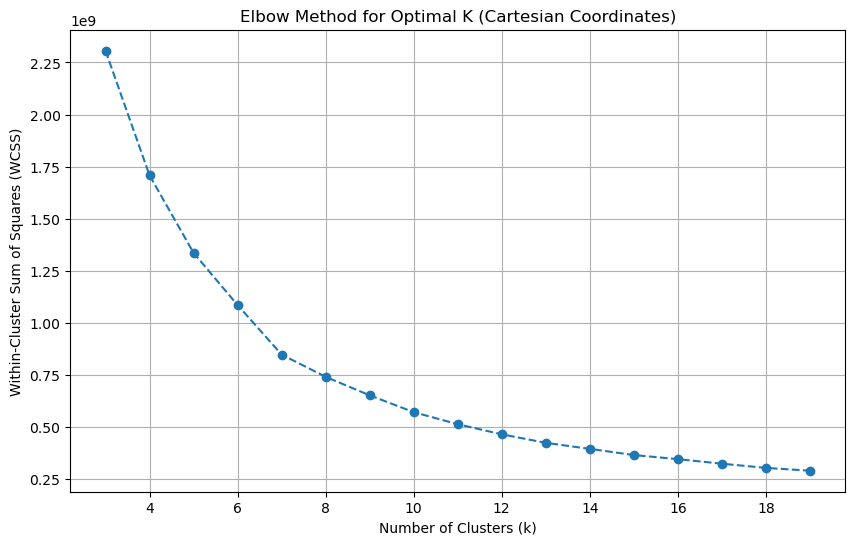

In [155]:
plt.figure(figsize=(10, 6))
plt.plot(k_values, wcss, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal K (Cartesian Coordinates)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.grid()
plt.show()

In [159]:
print(storm_data_df.duration_hours.describe())

count    54739.000000
mean       222.443760
std        119.353599
min          0.000001
25%        126.000000
50%        204.000000
75%        294.000000
max        786.000000
Name: duration_hours, dtype: float64
